# Class_imbalance_smote

Link referensi program

In [ ]:
Ref : https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7
Ref : https://www.kaggle.com/dark06thunder/credit-card-dataset?select=credit_dataset.csv 

,Unnamed: 0,ID,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
0,0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1.0,0.0,0.0,0.0,2.0,29.0,59.0,3.0,0.0
1,1,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,0.0,1.0,1.0,1.0,4.0,52.0,8.0,0.0
2,2,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,0.0,1.0,1.0,1.0,26.0,52.0,8.0,0.0
3,3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,0.0,1.0,1.0,1.0,26.0,52.0,8.0,0.0
4,4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1.0,0.0,1.0,1.0,1.0,38.0,52.0,8.0,0.0


# Mengimpor fungsi dan membaca karakteristik data

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('credit_dataset.csv')
df.head()

,Unnamed: 0,ID,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
0,0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,29,59,3,0
1,1,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,4,52,8,0
2,2,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,26,52,8,0
3,3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,26,52,8,0
4,4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,1.0,38,52,8,0


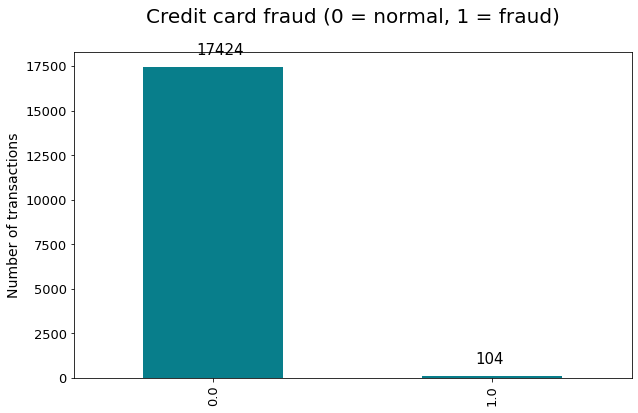

In [ ]:
ax = df['TARGET'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Credit card fraud (0 = normal, 1 = fraud)', size=20, pad=30)
ax.set_ylabel('Number of transactions', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)


Data preparation
You won’t spend much time here. The goal is to get a minimum viable dataset for machine learning.
Here’s the list of initial changes:
Remap gender, car, and reality to integers (0, 1) – these columns have only two possible values
Create dummy variables for income_type, education_type, family_name, house_type – to go from strings to binary (0, 1)
Drop unnecessary columns — Unnamed: 0, ID, and every column for which you created dummy variables
Merge all into a single data frame
Here’s the code for that:

In [ ]:
# Remap to integers
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]

# Create dummy variables
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)

# Drop unnecessary columns
to_drop = ['Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
merged.head()

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET,INC_TYPE_Pensioner,INC_TYPE_State servant,INC_TYPE_Student,INC_TYPE_Working,EDU_TYPE_Higher education,EDU_TYPE_Incomplete higher,EDU_TYPE_Lower secondary,EDU_TYPE_Secondary / secondary special,FAM_TYPE_Married,FAM_TYPE_Separated,FAM_TYPE_Single / not married,FAM_TYPE_Widow,HOUSE_TYPE_House / apartment,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_Office apartment,HOUSE_TYPE_Rented apartment,HOUSE_TYPE_With parents
0,0,1,1,0,112500.0,0,0,0,2.0,29,59,3,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0,270000.0,0,1,1,1.0,4,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
2,1,0,1,0,270000.0,0,1,1,1.0,26,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0,270000.0,0,1,1,1.0,26,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,1,0,1,0,270000.0,0,1,1,1.0,38,52,8,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


Better, but still needs a bit of work. Notice how larger the values are in income than in no_of_child. That’s expected, but machine learning algorithms will give more importance to variables on a larger scale. Introducing data scaling.
You’ll use MinMaxScaler from scikit-learn to scale columns that have values greater than 1 to [0, 1] range. Here’ how:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged[col] = scaled[col]
    
merged.head()

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET,INC_TYPE_Pensioner,INC_TYPE_State servant,INC_TYPE_Student,INC_TYPE_Working,EDU_TYPE_Higher education,EDU_TYPE_Incomplete higher,EDU_TYPE_Lower secondary,EDU_TYPE_Secondary / secondary special,FAM_TYPE_Married,FAM_TYPE_Separated,FAM_TYPE_Single / not married,FAM_TYPE_Widow,HOUSE_TYPE_House / apartment,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_Office apartment,HOUSE_TYPE_Rented apartment,HOUSE_TYPE_With parents
0,0,1,1,0.0,0.055233,0,0,0,0.052632,0.483333,0.826087,0.069767,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0.0,0.156977,0,1,1,0.000000,0.066667,0.673913,0.186047,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
2,1,0,1,0.0,0.156977,0,1,1,0.000000,0.433333,0.673913,0.186047,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0.0,0.156977,0,1,1,0.000000,0.433333,0.673913,0.186047,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
4,1,0,1,0.0,0.156977,0,1,1,0.000000,0.633333,0.673913,0.186047,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


Machine learning without SMOTE

In [ ]:
from sklearn.model_selection import train_test_split

X = merged.drop('TARGET', axis=1)
y = merged['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.69
% Positive class in Test  = 1.65


You’ll train a Random Forest classifier on the train set and evaluate it on the test set. Confusion matrix, accuracy score, and recall score will tell you just how bad is it:

(18850,)
Accuracy = 0.98
Recall = 0.09



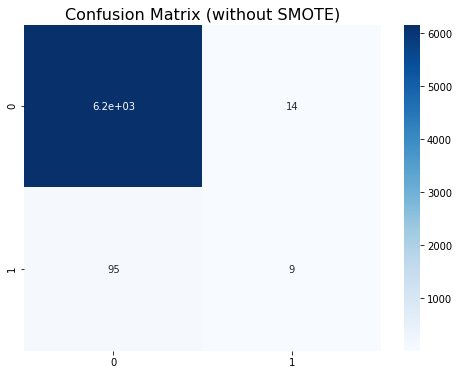

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(y_train.shape)
# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

Machine learning with SMOTE

In [ ]:
!pip install imbalanced-learn

# Menampilkan bentuk data setelah dilakukann SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')


Shape of X before SMOTE: (25134, 29)
Shape of X after SMOTE: (49424, 29)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Menampilkan bentuk data, dengan kolom kelas, dan pembagian persentase data train dan data test

In [ ]:
import numpy as np
import pandas as pd

X_d_sm = pd.DataFrame.from_records(X_sm)
y_d_sm = pd.DataFrame(y_sm, columns = ['class'])
y_d_sm.shape

(49424, 1)

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_d_sm, y_d_sm, test_size=0.25, random_state=42
)
print(f'''% Positive class in Train = {np.round(y_train_sm.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test_sm.value_counts(normalize=True)[1] * 100, 2)}''')



% Positive class in Train = class
1        49.87
dtype: float64
% Positive class in Test  = class
1        50.4
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy = 0.99
Recall = 0.99



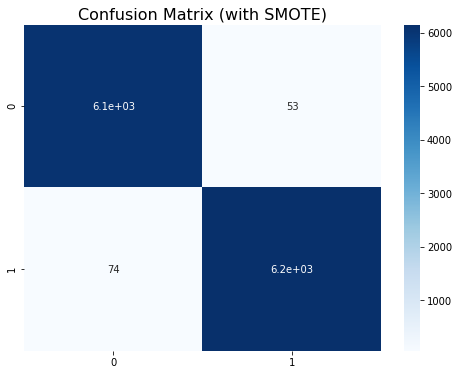

In [ ]:
model_sm = RandomForestClassifier(random_state=42)
model_sm.fit(X_train_sm, y_train_sm)
preds = model_sm.predict(X_test_sm)

print(f'Accuracy = {accuracy_score(y_test_sm, preds):.2f}\nRecall = {recall_score(y_test_sm, preds):.2f}\n')
cm = confusion_matrix(y_test_sm, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');